In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from math import pi

In [9]:
df = pd.read_csv('data.csv')
df.columns = df.columns.str.strip()

In [10]:
# Define the two subsets
zero_tax_firms = df[df['Tax rate (A)'] == 0]
tax_paying_firms = df[df['Tax rate (A)'] > 0]

# Slide 2: The Risk-Population Contrast

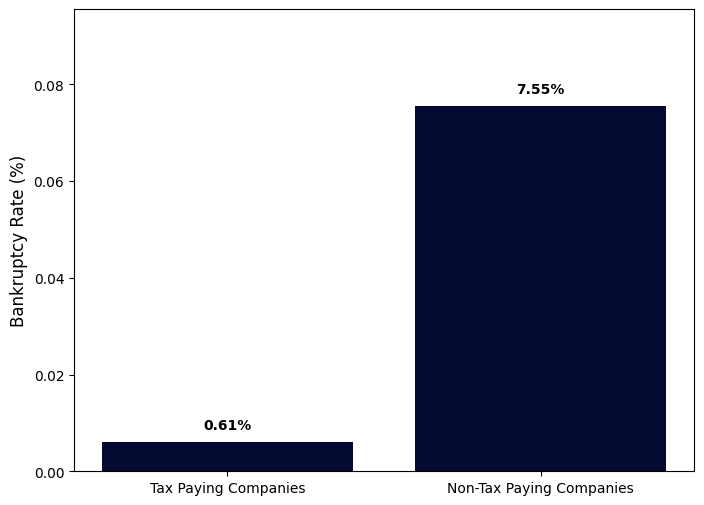

In [13]:
# Calculate the Bankruptcy Rates
zero_tax_rate = zero_tax_firms['Bankrupt?'].mean()
tax_paying_rate = tax_paying_firms['Bankrupt?'].mean()

# Create the Bar Chart
labels = ['Tax Paying Companies','Non-Tax Paying Companies']
rates = [tax_paying_rate, zero_tax_rate]

plt.figure(figsize=(8, 6))
bars = plt.bar(labels, rates, color=['#050a30'])

# Add title and labels
#plt.title('Bankruptcy Rate Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Bankruptcy Rate (%)', fontsize=12)
plt.ylim(0, max(rates) + 0.02) # Give some space for labels

# Add percentage labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002,
             f'{yval:.2%}', ha='center', va='bottom', fontweight='bold')

plt.show()

# Distribution of Companies by Tax Status

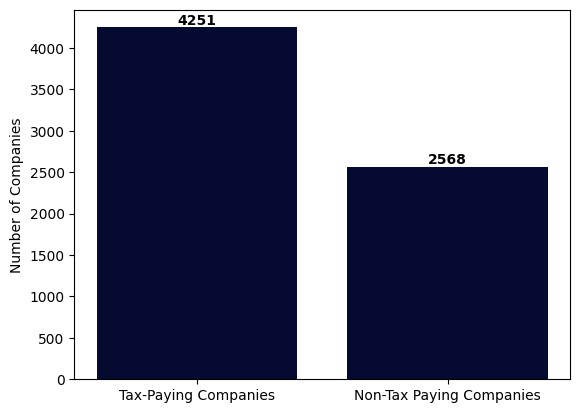

In [14]:
total_firms = len(df)
count_zero = len(zero_tax_firms)
count_paying = total_firms - count_zero

counts = [count_paying, count_zero]
labels = ['Tax-Paying Companies','Non-Tax Paying Companies']

# Bar chart
bars = plt.bar(labels, counts, color=['#050a30'])
# plt.title("Distribution of Firms by Tax Status")
plt.ylabel("Number of Companies")

# Add annotations (absolute count + percentage)
for bar, count in zip(bars, counts):
    percentage = (count / total_firms) * 100
    plt.text(
        bar.get_x() + bar.get_width()/2,   # x position (center of bar)
        bar.get_height(),                  # y position (top of bar)
        f'{count}',    # text: count
        ha='center', va='bottom', fontweight='bold'
    )

plt.show()

# Healthy vs. Bankrupt Zero-Tax Companies in terms of Growth

In [15]:
# Define the 2 Segments
groups = {
    "Healthy 0-Tax": df[(df['Bankrupt?'] == 0) & (df['Tax rate (A)'] == 0)],
    "Bankrupt 0-Tax": df[(df['Bankrupt?'] == 1) & (df['Tax rate (A)'] == 0)]
}

# Calculate metrics for each group
metrics = [
    'Research and development expense rate',
    'Total Asset Growth Rate'
]

plot_data = []
for name, subset in groups.items():
    for metric in metrics:
        plot_data.append({
            'Group': name,
            'Metric': metric,
            'Value': subset[metric].mean()
        })

plot_df = pd.DataFrame(plot_data)

In [16]:
# Helper function to format large numbers (e.g., 1.78e+09 -> 1.78B)
def format_label(value):
    if abs(value) >= 1e9:
        return f'{value/1e9:.2f}B'
    elif abs(value) >= 1e6:
        return f'{value/1e6:.2f}M'
    elif abs(value) >= 1e3:
        return f'{value/1e3:.2f}K'
    else:
        return f'{value:.3f}'

/tmp/ipython-input-3754730193.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='Group', y='Value', ax=ax, palette=colors)
/tmp/ipython-input-3754730193.py:9: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=subset, x='Group', y='Value', ax=ax, palette=colors)
/tmp/ipython-input-3754730193.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, x='Group', y='Value', ax=ax, palette=colors)
/tmp/ipython-input-3754730193.py:9: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(data=s

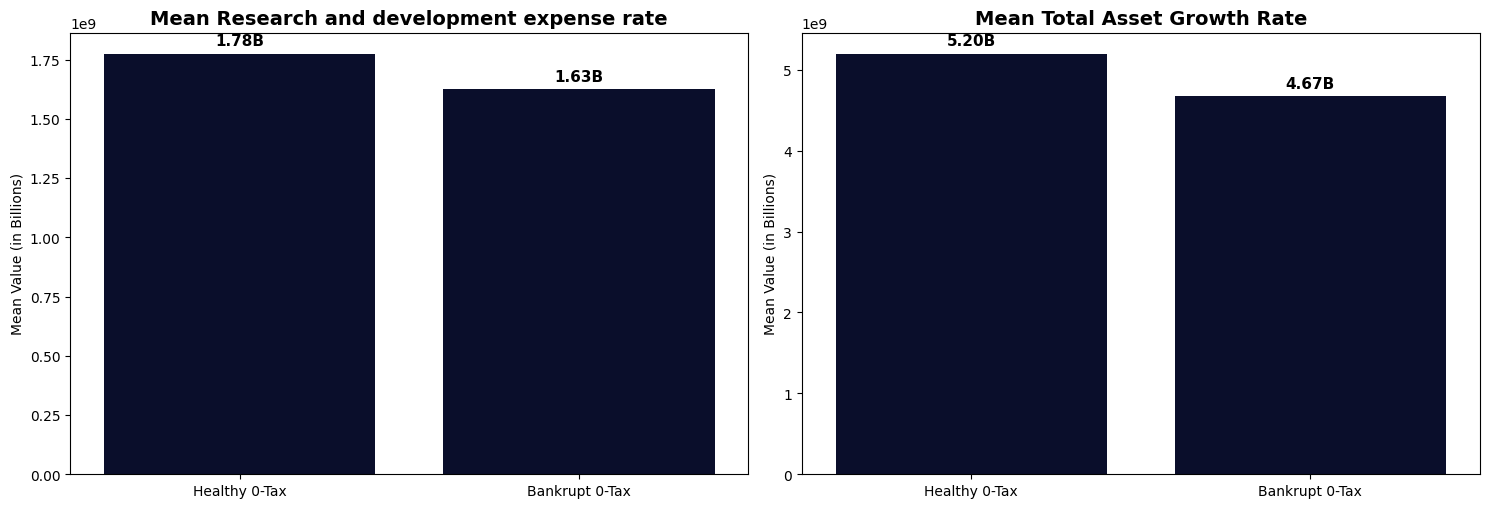

In [17]:
# Create the 2-Panel Comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

colors = ["#050a30"]

for i, metric in enumerate(metrics):
    ax = axes[i]
    subset = plot_df[plot_df['Metric'] == metric]
    sns.barplot(data=subset, x='Group', y='Value', ax=ax, palette=colors)

    ax.set_title(f'Mean {metric}', fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Mean Value (in Billions)')

    # Readable labels on bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(format_label(height),
                    (p.get_x() + p.get_width() / 2., height),
                    ha = 'center', va = 'center', xytext = (0, 9),
                    textcoords = 'offset points', fontsize=11, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

# Top Features of Global and Zero-Tax

In [18]:
def get_top_features(df, target_col, drop_cols=None, n_top=5):
    """
    Trains a Random Forest and returns the top N important features.

    Args:
        df: The dataframe subset to analyze.
        target_col: The target variable (e.g., 'bankrupt?').
        drop_cols: List of extra columns to remove (like 'tax_rate' in subsets).
    """
    if drop_cols is None:
        drop_cols = []

    # Define X and y (Exclude target and any specified drop_cols)
    X = df.drop(list(set(drop_cols + [target_col])), axis=1)
    y = df[target_col]

    # Train Model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)

    # Extract Importances
    importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False).head(n_top)

    return importances

In [19]:
def visualize_analysis(df, target_col, importance_df, title, color_hex='#050a30', base_fontsize=12):
    """Generates both the Importance Bar Plot and the Box Plot Grid."""

    # 1. Bar Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=importance_df, color=color_hex)
    plt.title(f'Feature Importance: {title}', fontsize=base_fontsize + 4)
    plt.xlabel('Importance', fontsize=base_fontsize)
    plt.ylabel('Feature', fontsize=base_fontsize)
    plt.xticks(fontsize=base_fontsize - 2)
    plt.yticks(fontsize=base_fontsize - 2)
    plt.show()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [21]:
target = 'Bankrupt?'

GLOBAL ANALYSIS


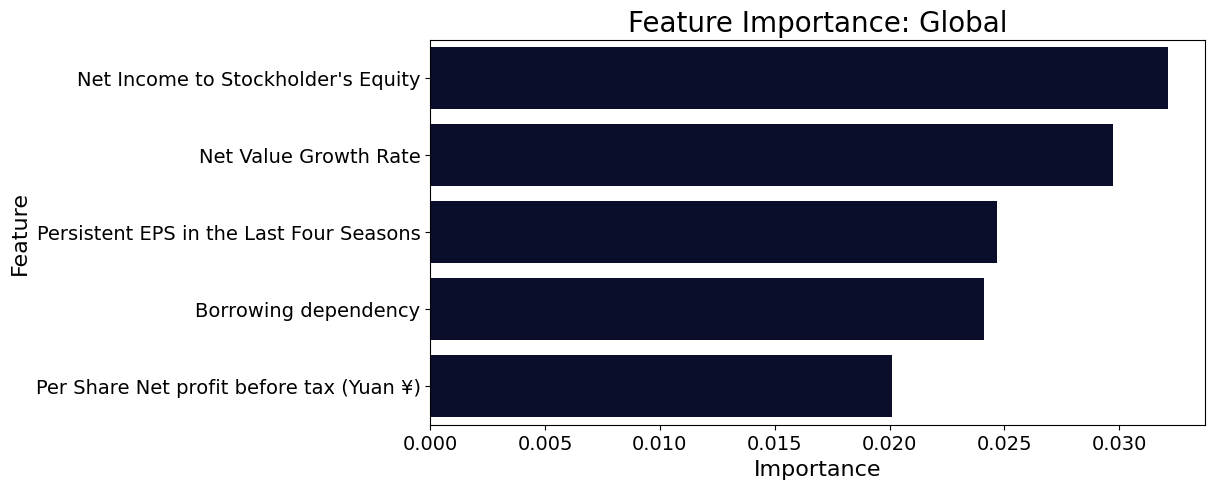

<Figure size 640x480 with 0 Axes>

In [22]:
print("GLOBAL ANALYSIS")
global_feats = get_top_features(df, target)
visualize_analysis(df, target, global_feats, "Global", color_hex='#050a30', base_fontsize=16)

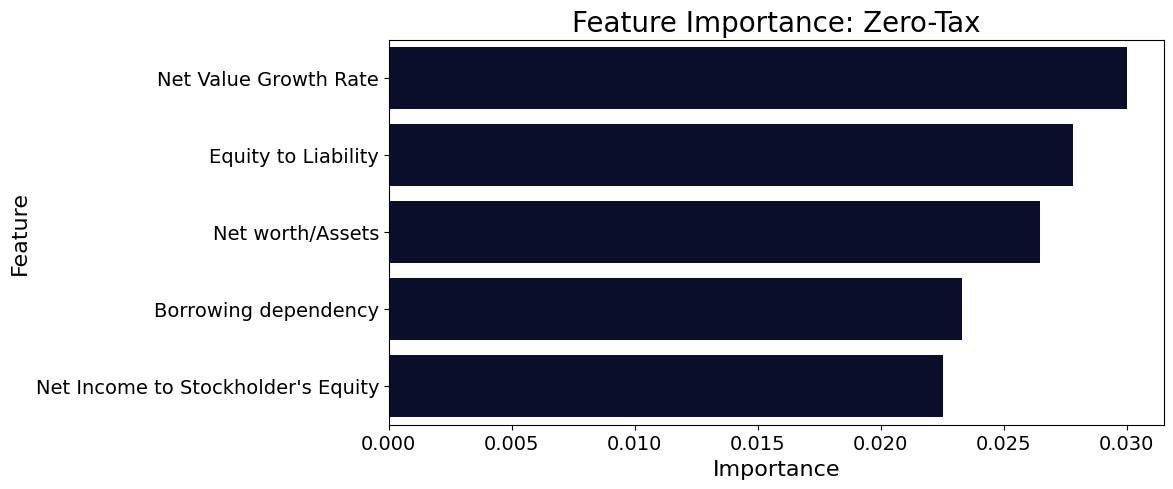

<Figure size 640x480 with 0 Axes>

In [23]:
zero_feats = get_top_features(zero_tax_firms, target, drop_cols=['Tax rate (A)'])
visualize_analysis(zero_tax_firms, target, zero_feats, "Zero-Tax", color_hex='#050a30', base_fontsize=16)

# Icarus Trap

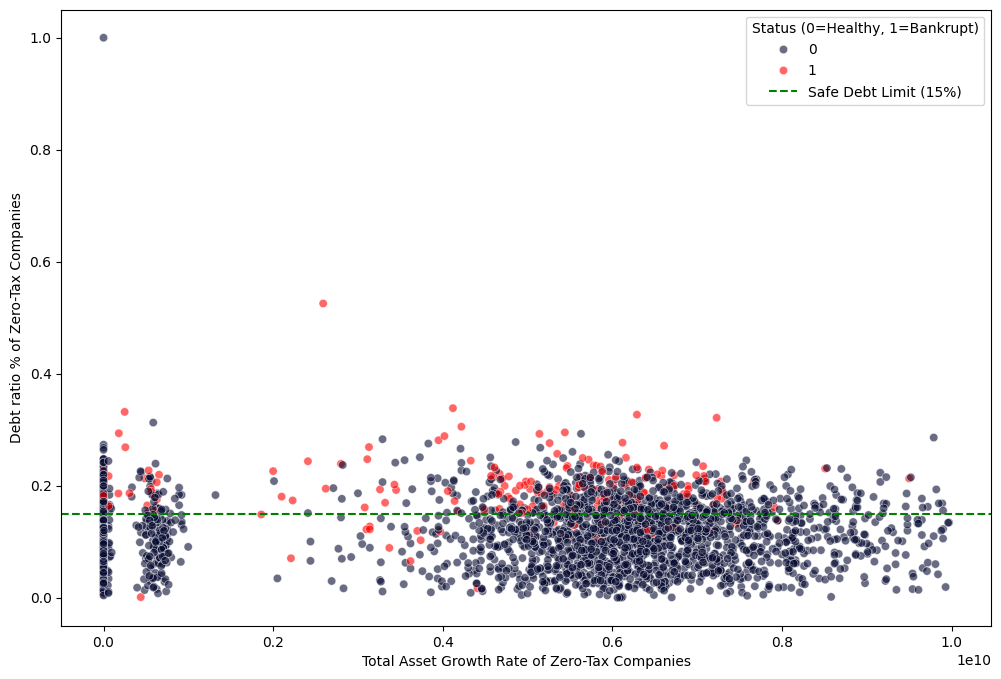

In [24]:
growth_col = 'Total Asset Growth Rate'
debt_col = 'Debt ratio %'

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=zero_tax_firms,
    x=growth_col,
    y=debt_col,
    hue='Bankrupt?',
    alpha=0.6,
    palette={0: '#050a30', 1: 'Red'}
)

# Add Threshold Lines (The "Danger Zone")
safe_debt_limit = 0.15 # Approx median for survivors
plt.axhline(y=safe_debt_limit, color='green', linestyle='--', label='Safe Debt Limit (15%)')

#plt.title('The Icarus Trap: Risky Growers (Zero-Tax)', fontsize=16)
plt.xlabel('Total Asset Growth Rate of Zero-Tax Companies')
plt.ylabel('Debt ratio % of Zero-Tax Companies')
plt.legend(title='Status (0=Healthy, 1=Bankrupt)')
plt.show()